# 5. Event Classification - Classifying Process Events With a Neural Network

In the last notebook a neural network was constructed and trained in keras. 

We will now use the newly gained insight to build and train a neural network suited for the classification of events that have been selected in the very first notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# open the neural network input vectors
nn_input = {}

# processes that will be used in training (bgr_Wj is excluded)
processes = ['signal', 'bgr_tt', 'bgr_st']

for process in processes:
    nn_input[process] = np.loadtxt('nn_input_' + process + '.txt', delimiter = ' ')
    
    # simplify data structure by transposing
    nn_input[process] = np.transpose(nn_input[process]).tolist()

## Neural network and training

Not only do we want to understand if the event in question is part of the signal or the background, we also want to be able to differentiate the various background processes. Essentially, we are building a *multiclassifier* neural network. This means that the network, instead of returning a binary "signal" or "background" response, returns an output vector of which each element is associated with the probablility of identifying the events as stemming from the various processes. In our case we have 3 processes that have to be distinguished from one another (the background W + jets is not being considered here, since it's sample size is too small to make any meaningful training with it); an exemplary output vector of the shape (0 0 1) would indicate the ideal case of identifying an event as a single top background event.

The process of constructing the neural network is shown in the following two cells and is very much reminiscient of how the exemplary neural network was set up in the third notebook. As to the structure of the network, in total 5 layers will be used where the input layer consists of 10 nodes corresponding to the various physical observables of the selected events, the output layer consists of 3 nodes corresponding to the three processes the events are meant to be classified as. The three hidden layers in between have 512 nodes. They are quite large such that they are capable of picking up on the differentiating nuances in the events. A certain number of hidden layers and their layer sizes directly affects the training duration. Thus the number of layers and layer sizes must be chosen in a way such that the training can be completed in a reasonable time frame.

In [3]:
# define structure of the network

# dimensions of input, hidden and output layers
N0 = len(nn_input['signal'][0])
N1 = 512
N2 = len(processes)

# number of hidden layers
layer_count = 3

# layer structure of the network
layers = [N0]

for l in range(layer_count):
    layers.append(N1)
    
layers.append(N2)

print("Layer structure of the network: ", layers)

Layer structure of the network:  [10, 512, 512, 512, 3]


The activation function of the output layer is chosen to be a *softmax* instead of the sigmoid that is being used everywhere else. That is because the softmax function in normalized in a way, such that the ouput is a number between 0 and 1 and can be read as a probability:

### $(1) \,\,\, \sigma(\vec{z})_{i} = \frac{e^{z_{i}}}{\sum{e^{z_{j}}}}$

In [4]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform

# construct the network in keras
net = Sequential()

# set the weights initializer
initializer = RandomUniform(minval = -1, maxval = 1)

# make the first layer with the input shape as an argument
net.add(Dense(layers[1], input_shape = (layers[0],), activation = 'sigmoid', 
              use_bias = True, kernel_initializer = initializer))

# make hidden layers
for i in range(2, len(layers) - 1):
    net.add(Dense(layers[i], activation = 'sigmoid', use_bias = True, kernel_initializer = initializer))

# make output layer
net.add(Dense(layers[-1], activation = 'softmax', use_bias = True, kernel_initializer = initializer))

2022-09-12 15:12:02.130770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 15:12:02.130813: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-12 15:12:04.689589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-12 15:12:04.689629: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-12 15:12:04.689664: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batch1361.desy.de): /proc/driver/nvidia/version does not exist
2022-09-12 15:12:04.689967: I tensorflow/core/platform/cpu_

In [5]:
# compile the network
net.compile(loss = 'categorical_crossentropy', 
            optimizer = keras.optimizers.SGD(learning_rate = 0.0001), 
            metrics = ['categorical_accuracy'])

As the processes from which the exact training events are made are known, it is very simple to generate the target output which will be used for verification during training. As discussed above the target vectors have three elements (as many elements as processes that are meant to be differentiated) which are 0 except one of them which is 1 corresponding to the process that the event in question originated from. There are as many target vectors being made as there are input vectors and depending on the process they are of the form (1 0 0), (0 1 0) or (0 0 1). Similar to the input vectors the target vectors are stored in a dictionary for the respective processes.

In [6]:
# making of the target output

# target dictionary
nn_target = {}

# make target data for a particular process
def make_target(p, proc):
    
    vectors = np.zeros((len(nn_input[proc]), len(processes)))
    vectors[:, p] = 1
    vectors = list(vectors)
    
    return vectors, len(vectors)

In [7]:
# make target data for all processes
for count, process in enumerate(processes):
    nn_target[process] = make_target(count, process)[0]

print(nn_target['signal'][10])

[1. 0. 0.]


In [8]:
# number of epochs
epochs = 200

# cost
costs = np.empty(epochs)

For the training ideally the same number of events for each process are used during training. This way the network won't focus on a particular process, which could lead to a very biased classification. In our case this can only fullfilled when using less than 4344 events for the processes respectively (number of signal events). There are far more background process events present than there are signal events. In spite of this disparity training can still be performed. For now, a limiter `max_limit` is set for the maximum number of events used from a process. The whole data set is split into training, validation and testing sets where the first 60% of events from each process are used for training, 20% are used for validation during training but not for training and the final 20% is used for testing, which the network is never exposed to during training.

In [9]:
# put input and target data all in one array

# storage lists for training data
nn_input_training = []
nn_target_training = []

# storage lists for validation data
nn_input_validation = []
nn_target_validation = []

# storage lists for test data
nn_input_test = []
nn_target_test = []

# splitting of data to training, validation and testing
full_split = np.array([len(nn_input[process]) for process in processes])

# maximum number of events to be used from each process
max_limit = 5000

for count, i in enumerate(full_split):
    if i >= max_limit:
        full_split[count] = max_limit

training_split = full_split * 6 // 10
validation_split = (full_split - training_split) // 2 + training_split
test_split = (full_split - training_split) + training_split

for count, process in enumerate(processes):
    # first 3000 events from each process are used for the training
    nn_input_training = nn_input_training + nn_input[process][:training_split[count]]
    nn_target_training = nn_target_training + nn_target[process][:training_split[count]]
    
    # remaining 1344 events are used for validation
    nn_input_validation = nn_input_validation + nn_input[process][training_split[count]:validation_split[count]]
    nn_target_validation = nn_target_validation + nn_target[process][training_split[count]:validation_split[count]]
    
    # for testing
    nn_input_test = nn_input_test + nn_input[process][validation_split[count]:test_split[count]]
    nn_target_test = nn_target_test + nn_target[process][validation_split[count]:test_split[count]]

nn_input_training = np.array(nn_input_training)
nn_target_training = np.array(nn_target_training)

nn_input_validation = np.array(nn_input_validation)
nn_target_validation = np.array(nn_target_validation)

nn_input_test = np.array(nn_input_test)
nn_target_test = np.array(nn_target_test)
    
print(np.shape(nn_input_training))
print(np.shape(nn_target_training))
print(np.shape(nn_input_validation))
print(np.shape(nn_target_validation))
print(np.shape(nn_input_test))
print(np.shape(nn_target_test))

(8606, 10)
(8606, 3)
(2869, 10)
(2869, 3)
(2869, 10)
(2869, 3)


Now that all the training and validation data is prepared the network is finally trained. For this the function `fit` is used, which takes training and validation data as arguments, takes the epochs i.e. the number of times the same batch of data should be trained on and most importantly shuffles the input data for training. This is very important to guarantee unbiased training. If this setting was `False` then the network's classification would scew towards the process which was trained on last. Training works best when the data to be classified is fed to the network in a random order, hence the shuffling. Additionally class weights are given for the various processes to make up for the event number disparity by making the network "pay more attention" to the classes which are underrepresented. The weights are chosen such that the product of the number of events of a process and its class weight equals the number of events of the process with the most events.

The function returns a history object which stores information about the performance of the network and the progression of the training. These metrics (loss, validation loss, categorical accuracy and validation categorical accuracy) can be viewed with the `history` attribute. 

In [10]:
print(full_split)

# class weight dictionary
class_weights = {}

# calculating class weights
for count, number in enumerate(full_split):
    class_weights[count] = np.max(full_split) / number
    
print(class_weights)

[4344 5000 5000]
{0: 1.1510128913443831, 1: 1.0, 2: 1.0}


In [11]:
# training
history = net.fit(x = nn_input_training, y = nn_target_training, epochs = epochs, class_weight = class_weights,
                  validation_data = (nn_input_validation, nn_target_validation), shuffle = True, verbose = 0)

In [12]:
# print history categories
for i in history.history:
    print(i)

loss
categorical_accuracy
val_loss
val_categorical_accuracy


The losses and accuracies of training and validation can be plotted and compared.

Lowest loss value:  1.0539062023162842


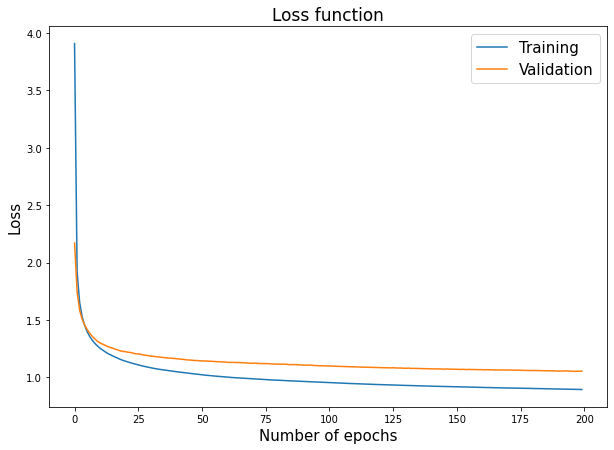

In [13]:
# plot of training and validation loss
print('Lowest loss value: ', history.history['val_loss'][-1])

plt.figure(figsize = (10, 7), facecolor = 'white')

plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')

plt.title('Loss function', fontsize = 17)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)

plt.legend(fontsize = 15)

plt.show()

Highest accuracy value:  0.5385151505470276


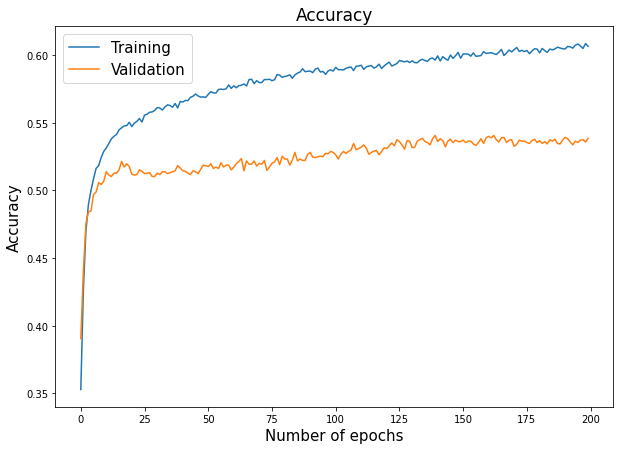

In [14]:
# plot of training and validation accuracy
print('Highest accuracy value: ', history.history['val_categorical_accuracy'][-1])

plt.figure(figsize = (10, 7), facecolor = 'white')

plt.plot(history.history['categorical_accuracy'], label = 'Training')
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation')

plt.title('Accuracy', fontsize = 17)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)

plt.legend(fontsize = 15)

plt.show()

Both loss functions feature a very nice exponential-decay-like shape suggesting a good fit of the weights of the neural network. The accuracy too has a desired shape although here the limitations of our network become evident. At the end of 200 epochs the training accuracy seems to still be rising while the validation accuracy has reached its plateau signaling further accuracy not to be achievable with more training of the same batch. In fact reusing the same training data for too long actually has a negative effect on the network performance. This is called *overfitting* and it's the idea that the network "learns the training data by heart" and fixates intrinsic event specific characteristics as relevant for the classification. Conceptually, overfitting can be understood with the following image:

<img src="images/overfitting.png" width = 600>

To combat overfitting three things can be done:

1. Early stopping: Train for short enough such that there's no time for overfitting to take place. This is essentially what we have done.
2. Use more data: Using more (varied) data in training diversifies the data set and allows for less epochs to be used.
3. Dropout: Artificially setting a certain number of weight values to 0 (or some other number or not consider the weights) during each step of gradient descent "keeps the neural network honest and open minded" so to speak. In mathematical terms, dropout prevents the neural network from falling into a local minimum for its fit of weights and not get out. 

Not visible in the loss (due to the current settings) but very much apparent in the accuracies are fluctuations. These fluctuations can be understood as making a step into the wrong or the right direction in finding the correct weight values and stand in strong correlation with the learning rate of the network. The greater the learning rate the stronger the fluctuations and vice versa:

<img src="images/learning_rate.png" width = 600>

## NN performance: ROC curve and AUC

More metrics about the performance of the neural network can be shown and read from the ROC curve and the AUC. 

The ROC curve, or receiver operating characteristic curve, shows the performance i.e. the classification ability of a binary classifier at various classification thresholds and is achieved by plotting the true positive rate against the false positive rate:

### $(1) \,\,\, TPR = \frac{TP}{TP + FN}$

### $(2) \,\,\, FPR = \frac{FP}{FP + TN}$

<img src="images/roc.png" width = 600>

The closer the curve is to show the constant line at 1 the better the classification of the network. Since our network, opposed to having a binary classifier, has a multiclassifier, the classification is either tested one class versus another class (OvO) or one class versus the rest (OvR). The calculation of the true/false positive rates is handled by the `roc_curve` function from the `sklearn.metrics` package. You can read more about this package in the [sklearn docs]()

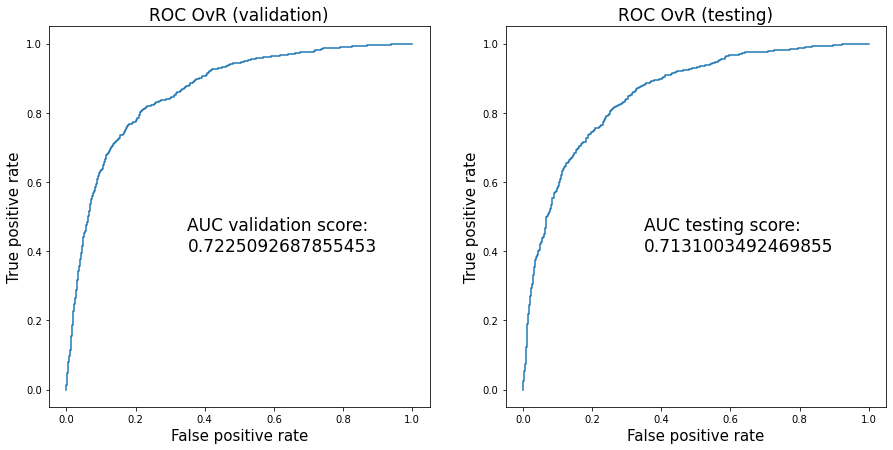

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# output prediction for roc curve
prediction_v = net.predict_on_batch(nn_input_validation)
prediction_t = net.predict_on_batch(nn_input_test)

# false/true positive rates and thresholds
fpr_v, tpr_v, thresholds_v = roc_curve(nn_target_validation[:, 0], prediction_v[:, 0])
fpr_t, tpr_t, thresholds_t = roc_curve(nn_target_test[:, 0], prediction_t[:, 0])

# auc
auc_score_v = roc_auc_score(nn_target_validation, prediction_v, average = 'macro', multi_class = 'ovr')
auc_score_t = roc_auc_score(nn_target_test, prediction_t, average = 'macro', multi_class = 'ovr')

fig = plt.figure(figsize = (15, 7), facecolor = 'white')

axes = np.array([fig.add_subplot(1, 2, i) for i in range(1, 3)])

# plot for validation
axes[0].plot(fpr_v, tpr_v)
axes[0].text(0.35, 0.4, f'AUC validation score: \n{auc_score_v}', fontsize = 17)

axes[0].set_title('ROC OvR (validation)', fontsize = 17)
axes[0].set_xlabel('False positive rate', fontsize = 15)
axes[0].set_ylabel('True positive rate', fontsize = 15)

# plot for testing
axes[1].plot(fpr_t, tpr_t)
axes[1].text(0.35, 0.4, f'AUC testing score: \n{auc_score_t}', fontsize = 17)

axes[1].set_title('ROC OvR (testing)', fontsize = 17)
axes[1].set_xlabel('False positive rate', fontsize = 15)
axes[1].set_ylabel('True positive rate', fontsize = 15)

plt.show()

A more general metric for the performance of a neural network is given by the area under the curve or AUC for short, which can be calculated with the `roc_auc_score` function from the `sklearn.metrics` package.

To study the exact classification of the various events into the process classes the confusion matrix is a very good visualization for this. It shows to what extent events with a certain label i.e. from a particular process are classified as such. This is shown in the following cell. The confusion matrix can be calculated using the function `confusion_matrix` from the package `sklearn.metrics`. As arguments it takes the classifications of both the predictions from the network as well as the targets, though not in the shape of the vectors (1 0 0) for example, but as classes 0 (signal), 1 (bgr_tt) and 2 (bgr_st). For that reason all the predictions and targets are first associated with these classes before `confusion_matrix` is run. `ConfusionMatrixDisplay` essentially does the same but in a nice plot.

In [16]:
def confusion_builder(nn_target_data, prediction_data):
    
    # class arrays for confusion matrix
    confused_targets = []
    confused_predictions = []

    for count, v in enumerate(nn_target_data):

        for j, i in enumerate(prediction_data[count]):

            if i == max(prediction_data[count]):
                confused_predictions.append(j)

        if list(v) == [1, 0, 0]:
            confused_targets.append(0)
        elif list(v) == [0, 1, 0]:
            confused_targets.append(1)
        else:
            confused_targets.append(2)

    return confused_targets, confused_predictions

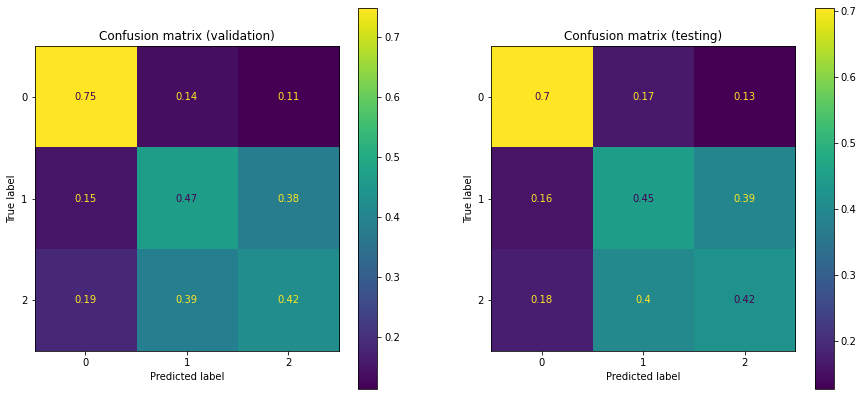

In [17]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

confusion_v = confusion_matrix(confusion_builder(nn_target_validation, prediction_v)[0], 
                               confusion_builder(nn_target_validation, prediction_v)[1], normalize = 'true')
confusion_t = confusion_matrix(confusion_builder(nn_target_test, prediction_t)[0], 
                               confusion_builder(nn_target_test, prediction_t)[1], normalize = 'true')

fig = plt.figure(figsize = (15, 7), facecolor = 'white')

axes = np.array([fig.add_subplot(1, 2, i) for i in range(1, 3)])

ConfusionMatrixDisplay(confusion_v).plot(ax = axes[0])
ConfusionMatrixDisplay(confusion_t).plot(ax = axes[1])

axes[0].set_title('Confusion matrix (validation)')
axes[1].set_title('Confusion matrix (testing)')

plt.show()

Taking a look at the confusion matrix it is clearly visible that the efficiency of classifying signal events as signal is "quite high" at roughly 70%. The same cannot be said about the top pair and single top background events. By the looks of it, the final states are too similar for the network to be able to differentiate the two, though, it is capable of generally differentiating signal from background which is already not bad. There's always room left for the network to be optimized, but this shall be left in your hands :)

And now, to finish off this notebook series, one last plot detailing the classification of the signal node in particular. A histogram is made showing and comparing the number of signal  and background events for various signal node values, which is once again a measure of the performance of the network. For this `hist` is used once more to construct and plot the histogram.

In [18]:
import hist

def hist_builder(prediction_input, split_1, split_2):
    
    predictions = {}

    for i, process in enumerate(processes):
        predictions[process] = net.predict_on_batch(np.array(prediction_input[process][split_1[i]:split_2[i]]))

    network_hist = (
            hist.Hist.new
            .StrCat(processes, name = "process", label = "process")
            .Reg(20, 0, 1, name = "classification", label = "Signal node classification")
            .Weight()
        )

    for count, process in enumerate(processes):

        network_hist.fill(
                process = process,
                classification = predictions[process][:, count],
                weight = class_weights[count],
            )
        
    return network_hist

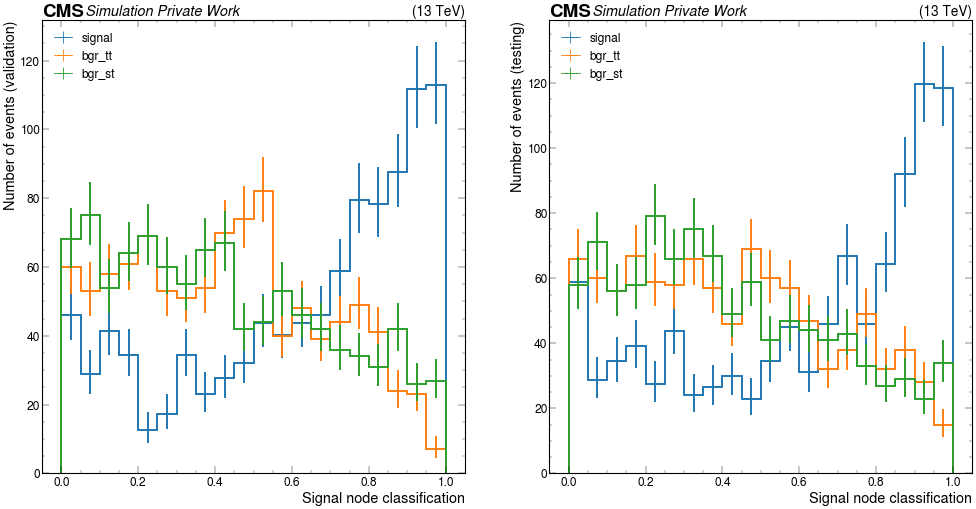

In [19]:
import mplhep

plt.style.use(mplhep.style.CMS)

fig = plt.figure(figsize = (30, 15), facecolor = 'white', dpi = 40)

axes = np.array([fig.add_subplot(1, 2, i) for i in range(1, 3)])

mplhep.cms.label(label="Private Work", ax = axes[0])
mplhep.cms.label(label="Private Work", ax = axes[1])

for count, process in enumerate(processes):

    hist_builder(nn_input, training_split, validation_split)[count, :].plot1d(
        ax = axes[0],
        overlay = "process",
        histtype = "step",
        stack = False,
        alpha = 1,
        # edgecolor = (0, 0, 0, 0.3),
        label = process,
        linewidth = 3.5,
    )

    hist_builder(nn_input, validation_split, test_split)[count, :].plot1d(
        ax = axes[1],
        overlay = "process",
        histtype = "step",
        stack = False,
        alpha = 1,
        # edgecolor = (0, 0, 0, 0.3),
        label = process,
        linewidth = 3.5,
    )

axes[0].set_ylabel('Number of events (validation)')
axes[1].set_ylabel('Number of events (testing)')
    
axes[0].legend()    
axes[1].legend()    
    
plt.show()

Comparing the validation and the testing of the last 3 pairs of plots, the ROC curves, confusion matrices and signal node classifications, it is evident that the neural network that we have constructed performs quite admirably and shows no signs of overfitting. This is suggested by how similar the network performs with data which wasn't used during training vs. data which was used during training.

You have now finished the introduction to CMS event selection and machine learning and can now call yourself a certified geek!

# BACKUP CELLS

## Image Sources

[Overfitting](    
https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/underfitting%2520and%2520overfitting%2520example.png)

[Learning rate](
https://miro.medium.com/proxy/0*QwE8M4MupSdqA3M4.png)

[ROC](
https://developers.google.com/static/machine-learning/crash-course/images/ROCCurve.svg)
